In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import os
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from fastai.vision.all import *
from sklearn.metrics import roc_auc_score
from torchvision.models import resnet50, densenet201, efficientnet_b3
from fastai.tabular.all import *
from sklearn.metrics import roc_auc_score
import torch
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-09-15 05:11:04.374849: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757913064.614249      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757913064.690854      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


## Data Cleaning and EDA

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [4]:
train_df.duplicated().sum()

0

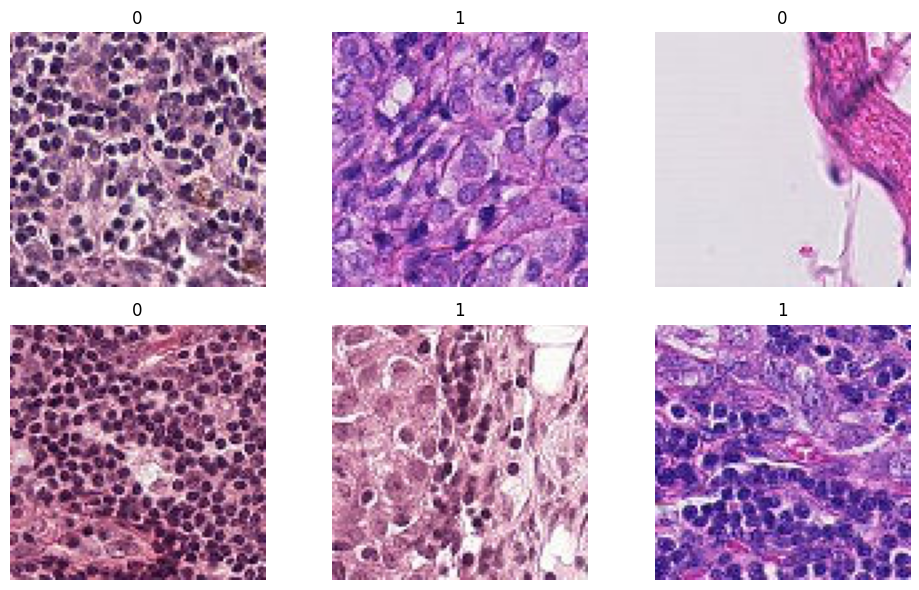

In [5]:
train_df['img_path'] = train_df['id'].apply(lambda x: os.path.join(
    '/kaggle/input/histopathologic-cancer-detection/train',f"{x}.tif"
))
def view_sample_images(df, no_sample =None,label_col =None, img_col='id'):
    sample_df = df.sample(no_sample)  
    plt.figure(figsize=(10, 6))
    
    for i, (_, row) in enumerate(sample_df.iterrows()):
        img = mpimg.imread(row[img_col])
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        if label_col:
            plt.title(str(row[label_col]))
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()
view_sample_images(train_df, no_sample =6,label_col ='label',img_col='img_path')

In [6]:
#Get image shape 
img = mpimg.imread(train_df['img_path'][0])
img.shape

(96, 96, 3)

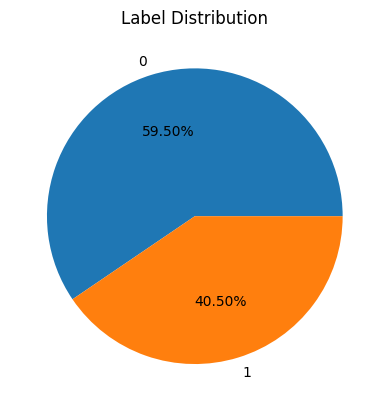

In [7]:
# Check class distribution 
labels = train_df['label'].value_counts(normalize=True)
plt.pie(labels,autopct='%1.2f%%',labels=labels.index)
plt.title('Label Distribution');

## Train Base Models (ResNet50, DenseNet201, EfficientNetB3)

In [8]:
def build_model(model_arch, batch_size=64, image_size=96, 
                validation_pct=0.2, 
                test_path='/kaggle/input/histopathologic-cancer-detection/test', 
                model_name='model'):
    """
    Train a CNN on train_df and save validation + test predictions for stacking.

    Args:
        model_arch: Fastai model architecture (resnet50, densenet201, efficientnet_b3)
        batch_size: batch size for training
        image_size: resize dimension for images
        validation_pct: fraction of data used for validation
        test_path: path to test images
        model_name: string used to save CSVs
    """
    # DataBlock & DataLoaders
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=ColReader('img_path'),
        get_y=ColReader('label'),
        splitter=RandomSplitter(valid_pct=validation_pct, seed=42),
        item_tfms=Resize(image_size),
        batch_tfms=[*aug_transforms(size=image_size), Normalize.from_stats(*imagenet_stats)]
    )
    dls = dblock.dataloaders(train_df, bs=batch_size)

    # Learner
    learn = vision_learner(dls, model_arch, metrics=[accuracy, RocAucBinary()])
    learn.to_fp16()  

    # Check if checkpoint exists: load if available
    model_path = f'{model_name}_checkpoint'
    try:
        learn = learn.load(model_path)
        print(f" Loaded checkpoint: {model_path}")
    except Exception as e:
        print("No checkpoint found, starting fresh training.")

    # model checkpoint callback
    cbs = [
        SaveModelCallback(monitor='roc_auc_score', fname=model_path),  # save best model
        CSVLogger(fname=f'{model_name}_history.csv')  # log training history
    ]
    learn.fine_tune(5, cbs=cbs)

    # Save validation predictions
    val_preds, val_targs = learn.get_preds(ds_idx=1)
    pd.DataFrame({
        'val_0': val_preds[:,0].numpy(),
        'val_1': val_preds[:,1].numpy(),
        'ground_truth_label': val_targs.numpy()
    }).to_csv(f'{model_name}_val_preds.csv', index=False)

    # Save test predictions
    test_files = get_image_files(test_path)
    test_dl = dls.test_dl(test_files)
    test_preds, _ = learn.get_preds(dl=test_dl)
    pd.DataFrame({
        'id': [f.stem for f in test_files],
        'pred_0': test_preds[:,0].numpy(),
        'pred_1': test_preds[:,1].numpy()
    }).to_csv(f'{model_name}_test_preds.csv', index=False)

    print(f"{model_name} training & predictions saved")

In [9]:
# Train ResNet50
build_model(resnet50, model_name='resnet50')

# Train DenseNet201
build_model(densenet201, model_name='densenet201')

# Train EfficientNetB3
build_model(efficientnet_b3, model_name='efficientnetb3', image_size=224)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 233MB/s]


No checkpoint found, starting fresh training.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.384009,0.366261,0.842541,0.917421,07:58


Better model found at epoch 0 with roc_auc_score value: 0.917421006952645.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.215861,0.209468,0.926122,0.972677,06:04
1,0.169406,0.158957,0.938871,0.984750,05:59
2,0.116713,0.128115,0.953142,0.989386,05:58
3,0.107260,0.110403,0.960504,0.991523,06:07
4,0.100521,0.107138,0.961913,0.991952,06:13


Better model found at epoch 0 with roc_auc_score value: 0.9726768651300813.
Better model found at epoch 1 with roc_auc_score value: 0.984749790065149.
Better model found at epoch 2 with roc_auc_score value: 0.9893859934686706.
Better model found at epoch 3 with roc_auc_score value: 0.9915228912494785.
Better model found at epoch 4 with roc_auc_score value: 0.9919516672395263.


resnet50 training & predictions saved


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 204MB/s]


No checkpoint found, starting fresh training.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.241999,0.197823,0.925645,0.974301,09:56


Better model found at epoch 0 with roc_auc_score value: 0.974301408958461.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.179680,0.146576,0.946006,0.985835,11:52
1,0.146940,0.123476,0.955596,0.989319,11:46
2,0.114228,0.112053,0.960141,0.991315,12:02
3,0.084064,0.094925,0.966617,0.993919,12:08
4,0.071784,0.095072,0.968367,0.994100,12:00


Better model found at epoch 0 with roc_auc_score value: 0.9858347355374303.
Better model found at epoch 1 with roc_auc_score value: 0.989319495544415.
Better model found at epoch 2 with roc_auc_score value: 0.9913154017665562.
Better model found at epoch 3 with roc_auc_score value: 0.9939185572386581.
Better model found at epoch 4 with roc_auc_score value: 0.9940999520699273.


densenet201 training & predictions saved


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 186MB/s]


No checkpoint found, starting fresh training.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.368147,0.322836,0.860811,0.931689,13:47


Better model found at epoch 0 with roc_auc_score value: 0.9316894927621009.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.290758,0.248543,0.901011,0.959996,20:19
1,0.237081,0.191899,0.929417,0.976342,20:19
2,0.210845,0.161213,0.940666,0.982776,20:18
3,0.195841,0.146308,0.946029,0.985555,20:21
4,0.182555,0.145474,0.945938,0.985720,20:19


Better model found at epoch 0 with roc_auc_score value: 0.9599959026356015.
Better model found at epoch 1 with roc_auc_score value: 0.9763418219524744.
Better model found at epoch 2 with roc_auc_score value: 0.9827759200416457.
Better model found at epoch 3 with roc_auc_score value: 0.9855551538144683.
Better model found at epoch 4 with roc_auc_score value: 0.9857195908760176.


efficientnetb3 training & predictions saved


In [10]:
# Load validation preds
res50_val = pd.read_csv('resnet50_val_preds.csv')
dense201_val = pd.read_csv('densenet201_val_preds.csv')
effb3_val = pd.read_csv('efficientnetb3_val_preds.csv')

# Load test preds
res50_test = pd.read_csv('resnet50_test_preds.csv')
dense201_test = pd.read_csv('densenet201_test_preds.csv')
effb3_test = pd.read_csv('efficientnetb3_test_preds.csv')

# Train stacking dataframe
train_stack = pd.DataFrame({
    'res50_0': res50_val.val_0, 'res50_1': res50_val.val_1,
    'dense201_0': dense201_val.val_0, 'dense201_1': dense201_val.val_1,
    'effb3_0': effb3_val.val_0, 'effb3_1': effb3_val.val_1,
    'y': res50_val.ground_truth_label
})

# Test stacking dataframe
test_stack = pd.DataFrame({
    'res50_0': res50_test.pred_0, 'res50_1': res50_test.pred_1,
    'dense201_0': dense201_test.pred_0, 'dense201_1': dense201_test.pred_1,
    'effb3_0': effb3_test.pred_0, 'effb3_1': effb3_test.pred_1
})


## Train Meta-Learner 

In [11]:
cont_names = list(train_stack.columns[:-1])  # model outputs
dep_var = 'y'

# Make y categorical
train_stack[dep_var] = train_stack[dep_var].astype(str)

# DataLoaders
splits = RandomSplitter(seed=42)(range_of(train_stack))
to = TabularPandas(train_stack, procs=[],
                   cont_names=cont_names,
                   y_names=dep_var,
                   y_block=CategoryBlock(),  
                   splits=splits)
dls = to.dataloaders(bs=64)

# Custom ROC AUC metric
def roc_score(inp, targ):
    # Convert to probabilities
    probs = inp.softmax(dim=1)[:,1].cpu().numpy()
    return roc_auc_score(targ.cpu().numpy(), probs)

# Meta-learner
learn = tabular_learner(dls, layers=[20,10],
                        metrics=[accuracy, roc_score],
                        wd=1e-2)

# Train
learn.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,accuracy,roc_score,time
0,0.179861,0.171121,0.959777,0.992410,00:03
1,0.105232,0.100158,0.967504,0.993366,00:03
2,0.086072,0.096244,0.968754,0.993372,00:03
3,0.087952,0.095728,0.967504,0.993415,00:04
4,0.079036,0.096001,0.967731,0.993588,00:04
5,0.085099,0.094056,0.968413,0.993435,00:04
6,0.075884,0.096348,0.968185,0.993703,00:03
7,0.090944,0.098099,0.968072,0.993546,00:03
8,0.078521,0.094256,0.968299,0.993577,00:04
9,0.088580,0.095846,0.966595,0.993411,00:03


In [12]:
# Predict on test set
test_dl = learn.dls.test_dl(test_stack)
preds, _ = learn.get_preds(dl=test_dl)

# Submission (probability for cancer class = column 1)
submission = pd.DataFrame({
    'id': res50_test.id,  # all test sets have same order
    'label': preds[:,1].numpy()
})

submission.to_csv('stacked_submission.csv', index=False)


## ImageDataGenerator

In [13]:
# #Extract image width and height info
# h,w = img.shape[:2]
# IMG_SIZE= (h,w)
# #Use ImageDataGenerator to rescale and split images 
# train_gen = ImageDataGenerator(
#     rescale =1./255,
#     validation_split = 0.25
# )

In [14]:
# # Use flow_from_dataframe to link image path to labels, 
# # split data into training and validation samples 
# # and generate training batches during training 
# train_generator = train_gen.flow_from_dataframe(
#     dataframe=train_df,
#     x_col='img_path',
#     y_col='label',
#     target_size=(96,96),
#     class_mode='raw',
#     batch_size=32,
#     shuffle=True,
#     seed=42,
#     directory=None ,
#     subset='training',
#     vertical_flip=True,
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     brightness_range=[0.9, 1.1]
# )

# valid_generator = train_gen.flow_from_dataframe(
#     dataframe=train_df,
#     x_col='img_path',
#     y_col='label',
#     target_size=(96,96),
#     class_mode='raw',
#     batch_size=32,
#     shuffle=False,
#     seed=42,
#     directory=None,
#     subset = 'validation'
# )


In [15]:
# base_model = EfficientNetB0(
#     input_shape=(96, 96, 3), 
#     weights='imagenet', 
#     include_top=False
# )
# base_model.trainable = True 

# # Build custom head
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
# output = Dense(1, activation='sigmoid')(x)

# model = Model(inputs=base_model.input, outputs=output)

# # Compile model
# optimizer = Adam(learning_rate=1e-4)
# model.compile(
#     optimizer=optimizer,
#     loss='binary_crossentropy',
#     metrics=[AUC(name='auc')]
# )

# # Callbacks
# early_stop = EarlyStopping(monitor='val_auc',
#                            patience=5, 
#                            mode='max', 
#                            restore_best_weights=True)
# lr_reduce = ReduceLROnPlateau(monitor='val_auc', 
#                               factor=0.2, 
#                               patience=2, 
#                               min_lr=1e-6, 
#                               mode='max')

# class_weights = compute_class_weight(class_weight='balanced',
#                                      classes=np.unique(train_df['label']),
#                                      y=train_df['label'])

# class_weights = dict(enumerate(class_weights))

# checkpoint = ModelCheckpoint(
#     'efficientnet_best.h5',   # file to save model
#     monitor='val_auc',        
#     mode='max',
#     save_best_only=True,
#     save_weights_only=False   # saves full model (weights + optimizer state)
# )

# callbacks = [early_stop, lr_reduce, checkpoint]
# # Train model
# history = model.fit(
#     train_generator,
#     validation_data=valid_generator,
#     epochs=50,
#     callbacks=[early_stop, lr_reduce],
#     class_weight=class_weights
# )

In [16]:
# #Extract training auc 
# auc = history.history['auc']
# #get validation auc
# val_auc = history.history['val_auc']

# epochs_range = range(len(auc))

# #plot training and validation auc curve 
# plt.plot(epochs_range, auc, 'r', label="Training AUC")
# plt.plot(epochs_range, val_auc, 'b', label="Validation AUC")
# plt.title("Training and Validation AUC")
# plt.legend()
# plt.show()